# Homework 1

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 123 (delta 48), reused 110 (delta 38), pack-reused 0
Receiving objects: 100% (123/123), 26.18 MiB | 27.53 MiB/s, done.
Resolving deltas: 100% (48/48), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_20

In [ ]:
from dul_2021.utils.hw1_utils import *

In [ ]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F

from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


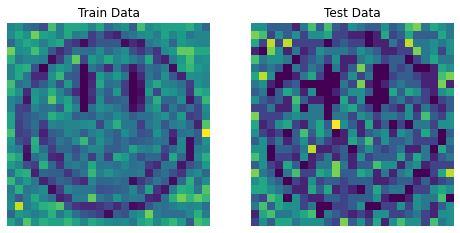

Dataset 2


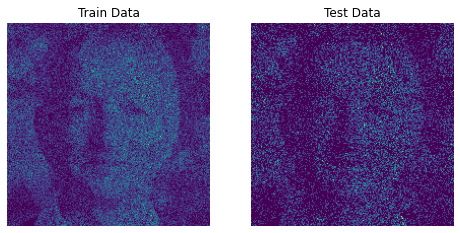

In [ ]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    
    def nll(self, batch):
        raise NotImplementedError()
    
    def probs(self):
        raise NotImplementedError()

    def test(self, data_loader):
        loss = 0
        den = 0
        for batch in data_loader:
            batch.to(device)
            batch_loss = self.nll(batch) * batch.shape[0]
            loss += batch_loss.cpu().detach().item()
            den += batch.shape[0]

        return loss / den

    def fit(self,
            train_data,
            test_data,
            num_epochs=10,
            batch_size=32,
            lr=1e-3,
            collator=None):
        

        train_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   collate_fn=collator)
        
        test_loader = torch.utils.data.DataLoader(train_data, 
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  collate_fn=collator)
        
        optim = opt.Adam(self.parameters(), lr)
        train_nll = []
        test_nll = []


        self.to(device)
        for epoch in range(num_epochs):
            tr_losses = []
            for batch in train_loader:
                batch = batch.to(device)

                loss = self.nll(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                tr_loss = loss.detach().cpu().item()
                # train_nll.append()
                tr_losses.append(tr_loss)
            train_nll.append(np.mean(tr_losses))
            print(f'Epoch {epoch}: {np.mean(tr_losses)}')
            
            test_loss = self.test(test_loader)
            test_nll.append(test_loss)

        return train_nll, test_nll

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [ ]:
# use CE
class MADE(Histogram):
    def __init__(self, in_dim=2, val_num=25, hidden_dim=150, hidden_layers_num=1):
        super().__init__(in_dim)

        self.m = {}

        # some init
        self.in_dim = in_dim
        self.val_num = val_num
        self.model = self.model_init(in_dim, val_num, hidden_dim, hidden_layers_num)

    def model_init(self, in_dim, val_num, hidden_dim, hidden_layers_num, ordering=None):
        if ordering is None:
            self.m[-1] = np.arange(in_dim)
        else:
            self.m[-1] = ordering

        # стакаем слои
        layers = []
        layer_0 = MaskedLinear(in_dim * val_num, hidden_dim)
        act_0 = nn.ReLU()
        layers.extend([layer_0, act_0])
        for i in range(hidden_layers_num - 1):
            self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)
            layer_i = MaskedLinear(hidden_dim, hidden_dim)
            act_i = nn.ReLU()
            layers.extend([layer_i, act_i])
        
        layer_n = MaskedLinear(hidden_dim, in_dim * val_num)
        layers.append(layer_n)
        i = hidden_layers_num - 1
        self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)


        # собираем маски и добавляем нагенеренные маски в соответствующие слои
        masks = [self.m[i-1][:, None] <= self.m[i][None, :] for i in range(hidden_layers_num)]
        masks.append(self.m[hidden_layers_num - 1][:, None] < self.m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], val_num, axis=1)
        masks[0] = np.repeat(masks[0], val_num, axis=0)
 
        for i in range(len(masks)):
            layers[2 * i].set_mask(masks[i])

        
        model = nn.Sequential(*layers)
        return model

    def forward(self, x):
        # x [bs, in_dim]
        x = F.one_hot(x, self.val_num).float() # [bs, in_dim, val_num]

        x = x.view(-1, self.in_dim * self.val_num)
        
        logits = self.model(x) # [bs, in_dim * val_num]
        return logits 

    def nll(self, batch):
        # batch [bs, in_dim]
        logits = self.forward(batch) # [bs, in_dim * val_num]
        logits = logits.view(-1, self.in_dim, self.val_num) 

        logits = logits.permute(0, 2, 1).contiguous().view(-1, self.val_num, self.in_dim)
        # logits = logits.view(-1, self.val_num, self.in_dim)
        return F.cross_entropy(logits, batch)


    def distribution(self):
        res = torch.zeros((self.val_num, self.val_num))

        for i in range(self.val_num):
            for j in range(self.val_num):
                out = self(torch.LongTensor([i, j]).reshape(1, -1))[0]
                out = out.reshape(2, -1)
                out = out.softmax(1)
                res[i, j] = out[0][i] * out[1][j]

        res = res.detach().numpy()
        return res

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
          
    model = MADE(2, 200, 264, 3)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-3, batch_size=1024)
    probs = model.distribution()
    return train_loss, test_loss, probs

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0: 3.2174434661865234
Epoch 1: 3.2129688560962677
Epoch 2: 3.209954619407654
Epoch 3: 3.2060933709144592
Epoch 4: 3.1997298896312714
Epoch 5: 3.1913645565509796
Epoch 6: 3.183836042881012
Epoch 7: 3.178650289773941
Epoch 8: 3.1748098731040955
Epoch 9: 3.172053813934326
Epoch 10: 3.1695152521133423
Epoch 11: 3.1675708293914795
Epoch 12: 3.164967894554138
Epoch 13: 3.1643353402614594
Epoch 14: 3.162823259830475
Epoch 15: 3.1621142625808716
Epoch 16: 3.161191165447235
Epoch 17: 3.159554421901703
Epoch 18: 3.1593383848667145
Epoch 19: 3.1594071686267853
Final Test Loss: 3.1567


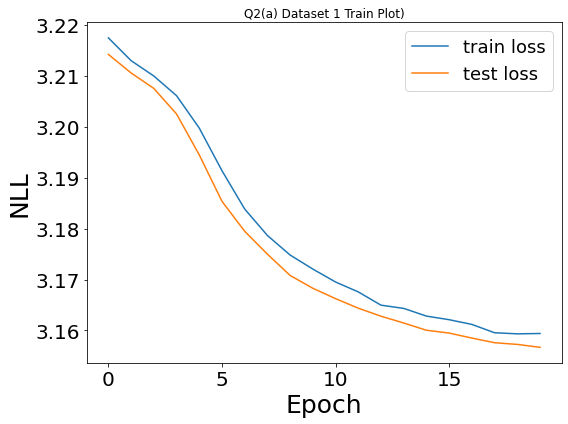

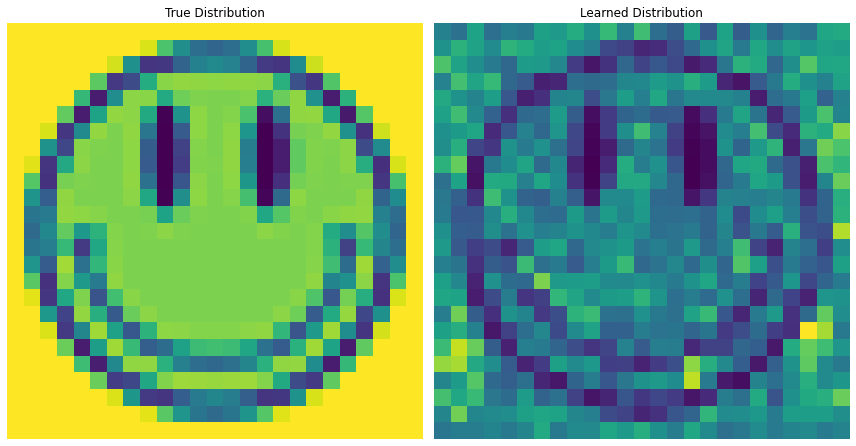

In [ ]:
q1_save_results(1, 'a', q1_a)

In [ ]:
# hinton

In [ ]:
# use BCE
class MADE(Histogram):
    def __init__(self, in_dim=2, val_num=25, hidden_dim=150, hidden_layers_num=1):
        super().__init__(in_dim)

        self.m = {}

        # some init
        self.in_dim = in_dim
        self.val_num = val_num
        self.model = self.model_init(in_dim, val_num, hidden_dim, hidden_layers_num)
        self.softmax = nn.Softmax(dim=2)

    def model_init(self, in_dim, val_num, hidden_dim, hidden_layers_num, ordering=None):
        if ordering is None:
            self.m[-1] = np.arange(in_dim)
        else:
            self.m[-1] = ordering

        # стакаем слои
        layers = []
        layer_0 = MaskedLinear(in_dim * val_num, hidden_dim)
        act_0 = nn.ReLU()
        layers.extend([layer_0, act_0])
        for i in range(hidden_layers_num - 1):
            self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)
            layer_i = MaskedLinear(hidden_dim, hidden_dim)
            act_i = nn.ReLU()
            layers.extend([layer_i, act_i])
        
        layer_n = MaskedLinear(hidden_dim, in_dim * val_num)
        layers.append(layer_n)
        i = hidden_layers_num - 1
        self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)


        # собираем маски и добавляем нагенеренные маски в соответствующие слои
        masks = [self.m[i-1][:, None] <= self.m[i][None, :] for i in range(hidden_layers_num)]
        masks.append(self.m[hidden_layers_num - 1][:, None] < self.m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], val_num, axis=1)
        masks[0] = np.repeat(masks[0], val_num, axis=0)
 
        for i in range(len(masks)):
            layers[2 * i].set_mask(masks[i])

        model = nn.Sequential(*layers)
        return model


    def forward(self, x):

        x = x.view(-1, self.in_dim * self.val_num)
        logits = self.model(x) 
        logits = logits.reshape(-1, self.in_dim, self.val_num)
        probs = self.softmax(logits)
        return probs 


    def nll(self, batch):

        probs = self.forward(batch.float()) # [bs, in_dim * val_num]
        probs = probs.view(-1, self.in_dim, self.val_num) 
  
        return nn.BCELoss()(probs, batch.float()) 


    def distribution(self):
        res = torch.zeros((200, 200))
        Y = torch.eye(200)
        X = torch.eye(200)

        for i, y in enumerate(Y):
            for j, x in enumerate(X):
                out = self.model(torch.hstack([y, x]).reshape(1, -1))[0]
                out = out.reshape(2, -1)
                out = out.softmax(1)
                res[i, j] = out[0][i] * out[1][j]

        return res.detach().numpy()

In [ ]:
def collator(x):

    x = torch.LongTensor(x)
    x = F.one_hot(x, 200)

    return x.long() 

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
          
    model = MADE(2, 200, 100, 1)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-3, batch_size=1024, collator=collator)
    probs = model.distribution()
    return train_loss, test_loss, probs

Epoch 0: 0.03144408097561402
Epoch 1: 0.03136896690990351
Epoch 2: 0.03135012406148488
Epoch 3: 0.03133376107751569
Epoch 4: 0.031315268312073964
Epoch 5: 0.031294121607383596
Epoch 6: 0.03127111709099027
Epoch 7: 0.03124609754621228
Epoch 8: 0.031220093133706082
Epoch 9: 0.031196248988750615
Epoch 10: 0.031173495575785637
Epoch 11: 0.03114883886956716
Epoch 12: 0.03112844512149503
Epoch 13: 0.031108564614683767
Epoch 14: 0.031089104877053936
Epoch 15: 0.031072176686381993
Epoch 16: 0.031054140929179855
Epoch 17: 0.0310414325493046
Epoch 18: 0.031026056390019912
Epoch 19: 0.031015668606644946
Final Test Loss: 0.0310


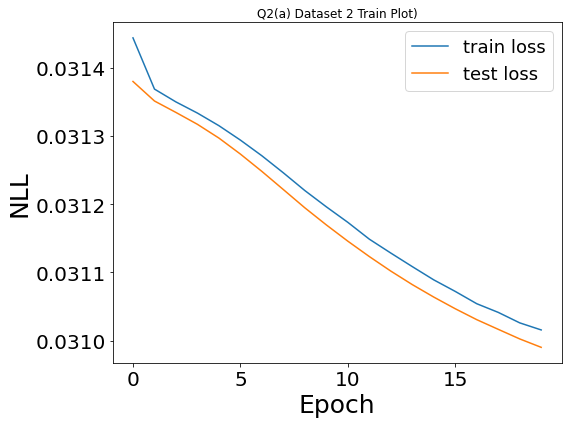

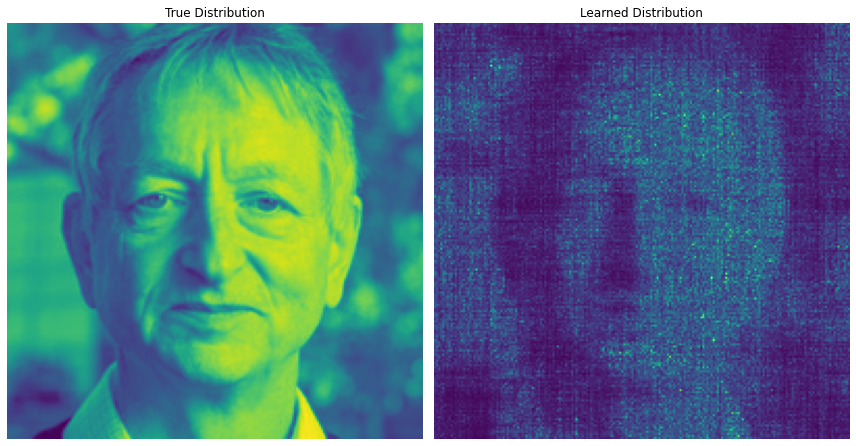

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

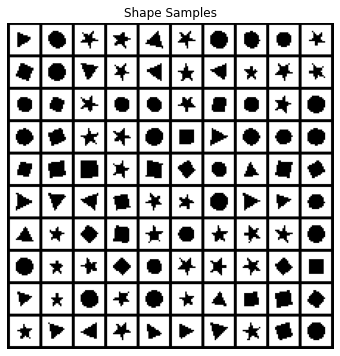

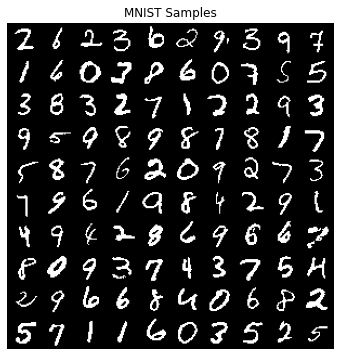

In [ ]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
data = get_data_q1_b(dset_type=1)
len(data)

10479

In [ ]:
data[0].shape

(20, 20, 1)

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):

        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [ ]:

class MADE(Histogram):
    def __init__(self, in_dim=400, val_num=2, hidden_dim=150, hidden_layers_num=1):
        super().__init__(in_dim)

        self.m = {}

        # some init
        self.in_dim = in_dim
        self.val_num = val_num
        self.model = self.model_init(in_dim, val_num, hidden_dim, hidden_layers_num)
        self.softmax = nn.Softmax(dim=2)

    def model_init(self, in_dim, val_num, hidden_dim, hidden_layers_num, ordering=None):
        if ordering is None:
            self.m[-1] = np.arange(in_dim)
        else:
            self.m[-1] = ordering

        # стакаем слои
        layers = []
        layer_0 = MaskedLinear(in_dim * val_num, hidden_dim)
        act_0 = nn.ReLU()
        layers.extend([layer_0, act_0])
        for i in range(hidden_layers_num - 1):
            self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)
            layer_i = MaskedLinear(hidden_dim, hidden_dim)
            act_i = nn.ReLU()
            layers.extend([layer_i, act_i])
        
        layer_n = MaskedLinear(hidden_dim, in_dim * val_num)
        layers.append(layer_n)
        i = hidden_layers_num - 1
        self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)


        # собираем маски и добавляем нагенеренные маски в соответствующие слои
        masks = [self.m[i-1][:, None] <= self.m[i][None, :] for i in range(hidden_layers_num)]
        masks.append(self.m[hidden_layers_num - 1][:, None] < self.m[-1][None, :])
        
        masks[-1] = np.repeat(masks[-1], val_num, axis=1)
        masks[0] = np.repeat(masks[0], val_num, axis=0)
 
        for i in range(len(masks)):
            layers[2 * i].set_mask(masks[i])

        model = nn.Sequential(*layers)
        return model

    def forward(self, x):
        x = x.view(-1, self.in_dim * self.val_num)
        logits = self.model(x) # [bs, in_dim * val_num]
        logits = logits.reshape(-1, self.in_dim, self.val_num)
        probs = self.softmax(logits)
        return probs 

    def nll(self, batch):
        probs = self.forward(batch.float()) 
        probs = probs.view(-1, self.in_dim, self.val_num)
        return nn.BCELoss()(probs, batch.float())



    def sample(self,):
        with torch.no_grad():
            res = torch.zeros((1, self.in_dim, 2)).to(device)
            for j in range(self.in_dim):
                out = self(res.reshape(1, -1))
                out = out.squeeze(0)
                probs = out[j].numpy()
                idx = np.random.choice(2, p=probs)
                res[:, j, idx] = 1
        return res

In [ ]:
def collator(x):
    
    x = torch.LongTensor(x)
    x = x.reshape(-1, 400)
    x = F.one_hot(x, 2)
    return x.float()


In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    model = MADE(400, 2, 128, 3)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-3, batch_size=2048, collator=collator)


    n_samples = 100
    h = 20
    w = 20
    samples = []
    for _ in range(100):
        s = model.sample().cpu().numpy()
        samples.append(s)
    samples = np.argmax(samples, axis=-1).reshape(n_samples, h, w, 1)

    return train_loss, test_loss, samples

Epoch 0: 0.6882873674233755
Epoch 1: 0.6599262654781342
Epoch 2: 0.5967549383640289
Epoch 3: 0.5041716595490774
Epoch 4: 0.43836503724257153
Epoch 5: 0.40359993775685626
Epoch 6: 0.37346992393334705
Epoch 7: 0.34559544920921326
Epoch 8: 0.3211711297432582
Epoch 9: 0.3019414742787679
Epoch 10: 0.28750119109948474
Epoch 11: 0.27556312084198
Epoch 12: 0.2664346247911453
Epoch 13: 0.257747823993365
Epoch 14: 0.25155534346898395
Epoch 15: 0.24537992229064307
Epoch 16: 0.23918117334445319
Epoch 17: 0.23426849643389383
Epoch 18: 0.22886158525943756
Epoch 19: 0.2239470953742663
Final Test Loss: 0.2214


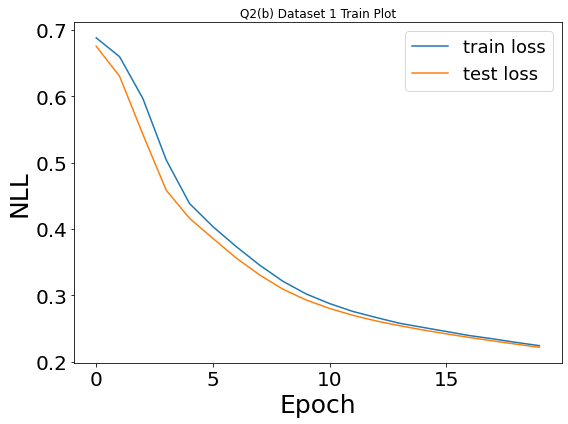

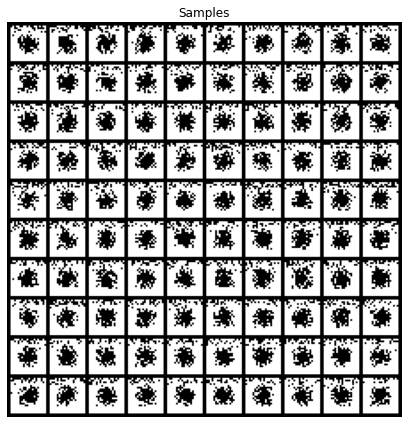

In [ ]:
q1_save_results(1, 'b', q1_b)

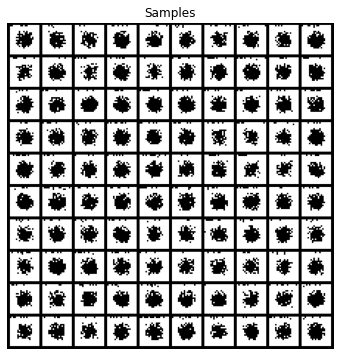

In [ ]:
# 50 эпох

show_samples(samples)

In [ ]:
# нужно подбирать параметры/архитектуру, возможно долбше обучать

In [ ]:
def collator(x):
    
    x = torch.LongTensor(x)
    x = x.reshape(-1, 784)
    x = F.one_hot(x, 2)
    return x.float()

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    model = MADE(784, 2, 128, 3)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=10, lr=1e-3, batch_size=2048, collator=collator)

    # probs = model.distribution()

    n_samples = 100
    h = 28
    w = 28
    samples = []
    for _ in range(100):
        s = model.sample().cpu().numpy()
        samples.append(s)
    samples = np.argmax(samples, axis=-1).reshape(n_samples, h, w, 1)

    return train_loss, test_loss, samples

Epoch 0: 0.5880986303091049
Epoch 1: 0.4271932989358902
Epoch 2: 0.3597876300414403
Epoch 3: 0.3288221697012583
Epoch 4: 0.3142503847678502
Epoch 5: 0.302505420645078
Epoch 6: 0.2921957761049271
Epoch 7: 0.2862658431132635
Epoch 8: 0.2818496584892273
Epoch 9: 0.27805803120136263
Final Test Loss: 0.2762


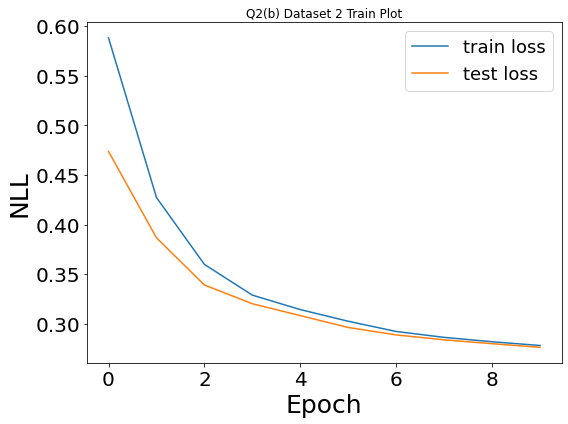

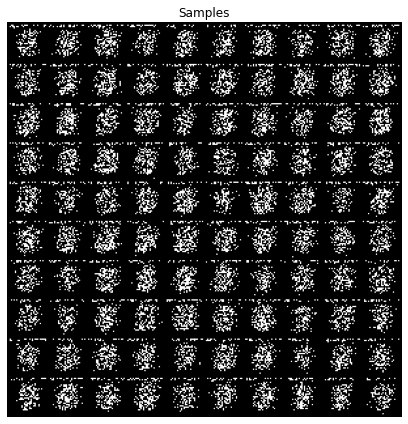

In [ ]:
q1_save_results(2, 'b', q1_b)

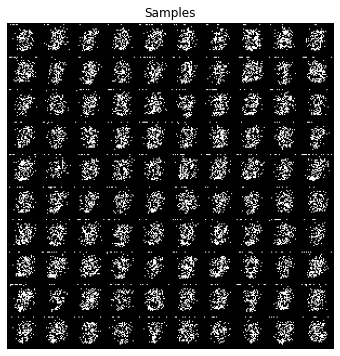

In [ ]:
# 20 эпох

show_samples(samples)

In [ ]:
# нужно подбирать параметры/архитектуру, возможно долбше обучать

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.1371


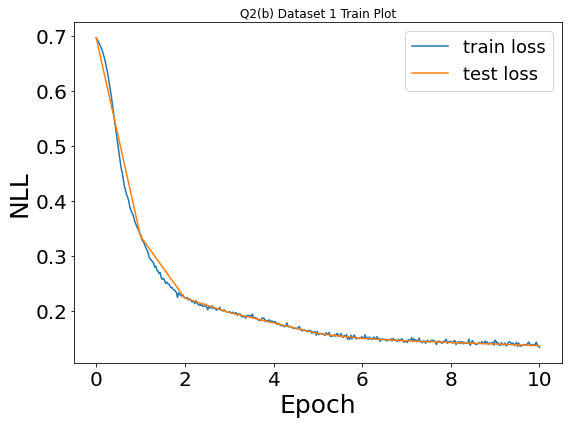

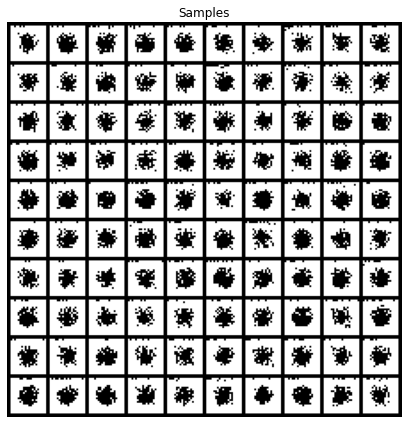

In [ ]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 0.1911


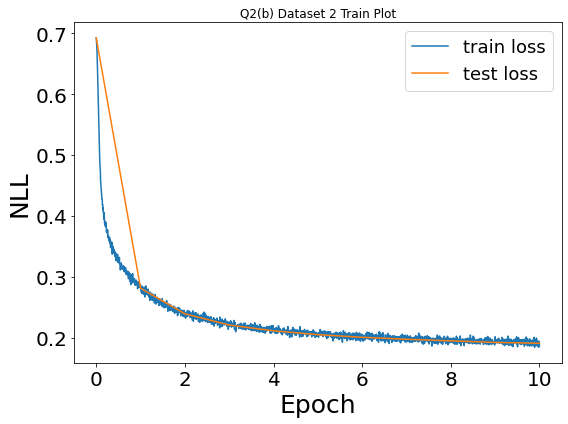

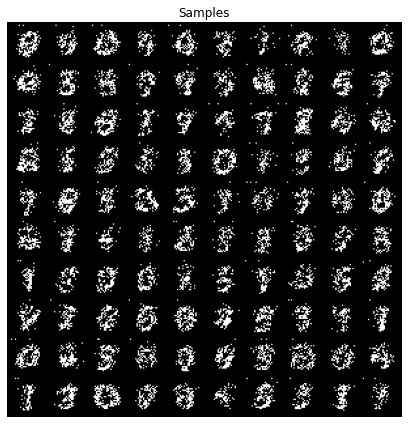

In [ ]:
q1_save_results(2, 'b', q1_b)